In [1]:
import matplotlib.pyplot as plt

import initialconditions as ic

import main as main
import sys
sys.path.append("/home/s2250115/petsc/arch-linux-c-debug/lib")

import animators as ani

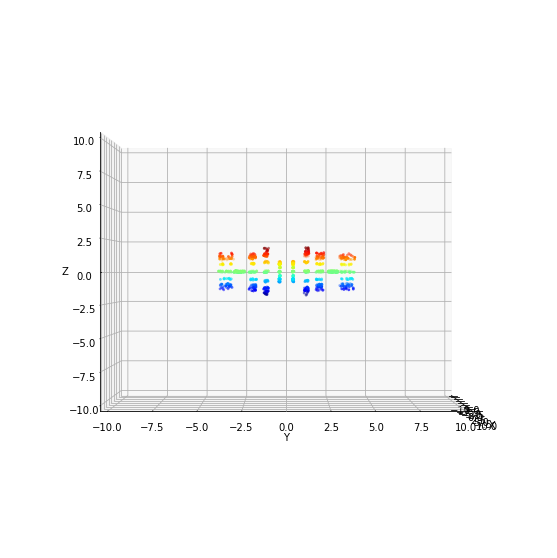

In [2]:
# Define the parameters of the system

N = 1000 # Number of seeds
box = [-3, -3, 0, 3, 3, 1] # List or tuple defining domain [xmin, ymin, zmin, xmax, ymax, zmax]
per_tol = 1e-3 # Percent tolerance
per_x = False # Set the periodicity of X
per_y = False # Set the periodicity of Y
per_z = False # Set the periodicity of Z
tf = 0.1 # Final time
Ndt = 10 # Number of timesteps

#Initialize initial condition
Z = ic.create_initial(N, -4, -4, 0, 4, 4, 4, 'lattice wsp') #Initial seed positions

# Plot the initial condition

fig = plt.figure()
fig.set_size_inches(10, 10, True)
ax = fig.add_subplot(projection='3d')
ax.scatter(Z[:,0], Z[:,1], Z[:,2], c = Z[:,2], cmap = 'jet', edgecolor = 'none', s = 8)
ax.set_xlim([-10, 10])
ax.set_ylim([-10, 10])
ax.set_zlim([-10, 10])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(elev = 0, azim = 0)

plt.show()

In [3]:
main.SGSolver(box, Z, N, per_tol, tf, Ndt, per_x, per_y, per_z) #Solve and save the solution

0
1
2
3
4
5
6
7
8
9


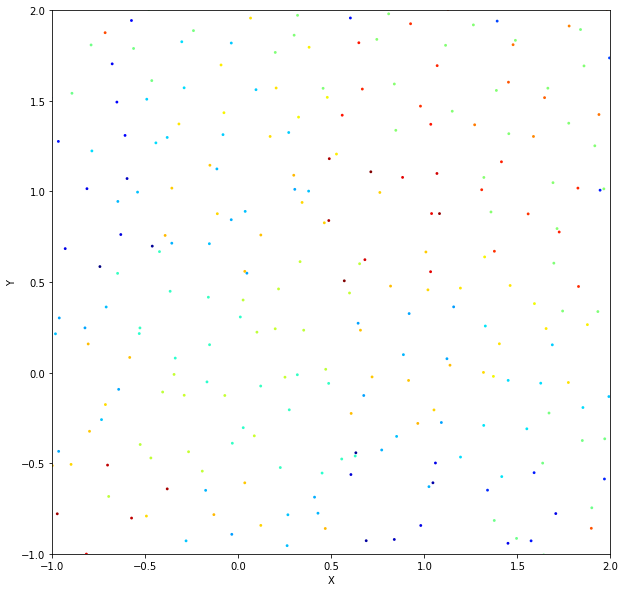

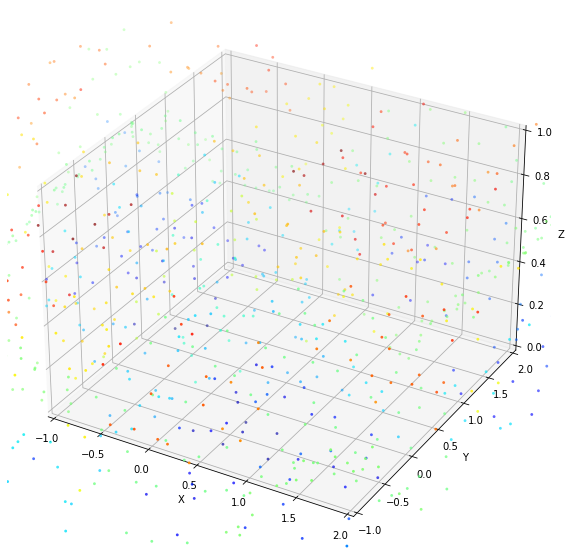

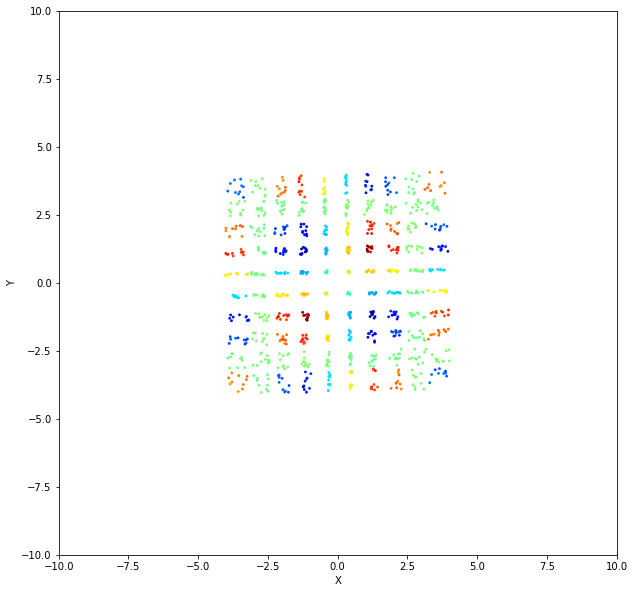

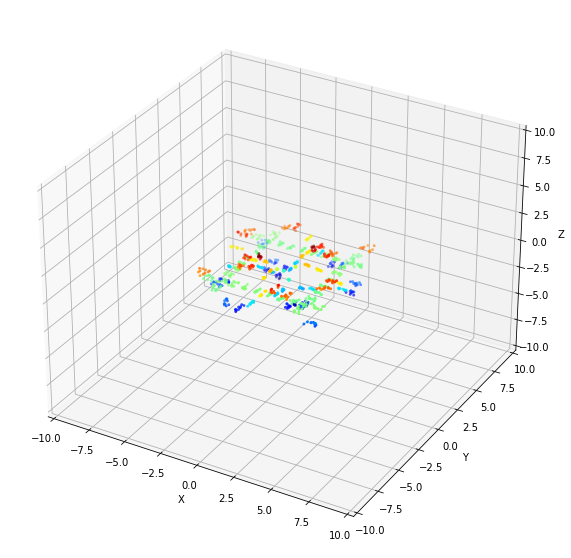

In [4]:
ani.point_animator('./SG_data.npz', 'C', '2D', tf) #Animate the seeds or centroids depending on choice of 'Z' or 'C' and '2D' or '3D'
ani.point_animator('./SG_data.npz', 'C', '3D', tf) #Animate the seeds or centroids depending on choice of 'Z' or 'C' and '2D' or '3D'
ani.point_animator('./SG_data.npz', 'Z', '2D', tf) #Animate the seeds or centroids depending on choice of 'Z' or 'C' and '2D' or '3D'
ani.point_animator('./SG_data.npz', 'Z', '3D', tf) #Animate the seeds or centroids depending on choice of 'Z' or 'C' and '2D' or '3D'
ani.cell_animator('./SG_data.npz', box) #Animate the cells